In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Dummify Nominal Features

In [3]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold']

In [4]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Remove original columns that have been ordinalized

In [5]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Build base model

In [6]:
y = df['SalePrice'];
x = df.drop(['SalePrice', 'PID'], axis = 1)

In [7]:
rf = RandomForestRegressor();
rf.set_params(random_state=0);

rf.fit(x, y)

RandomForestRegressor(random_state=0)

In [8]:
rf.score(x, y)

0.986014214405674

In [9]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":rf.feature_importances_})

In [10]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

,Features,Importance
3,OverallQual,0.565590
0,GrLivArea,0.154469
12,1stFlrSF,0.050097
11,TotalBsmtSF,0.034333
8,BsmtFinSF1,0.026955
25,GarageArea,0.015297
2,LotArea,0.015263
7,MasVnrArea,0.009883
5,YearBuilt,0.008039
13,2ndFlrSF,0.007705


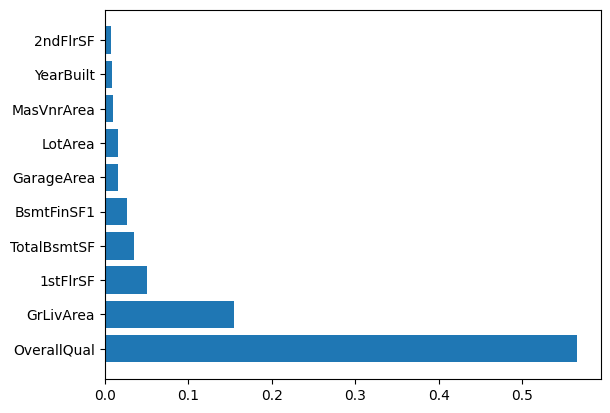

In [11]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0);


rf.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [13]:
# overfitting issue 
print("The train score: %.4f" %rf.score(x_train, y_train));
print("The test score: %.4f" %rf.score(x_test, y_test));

The train score: 0.9831
The test score: 0.9093


In [14]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":rf.feature_importances_})

In [15]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

,Features,Importance
3,OverallQual,0.565176
0,GrLivArea,0.147575
12,1stFlrSF,0.031172
11,TotalBsmtSF,0.028894
8,BsmtFinSF1,0.025099
25,GarageArea,0.020532
7,MasVnrArea,0.019644
2,LotArea,0.012590
34,GarageFinish_ordinal,0.011812
13,2ndFlrSF,0.009235


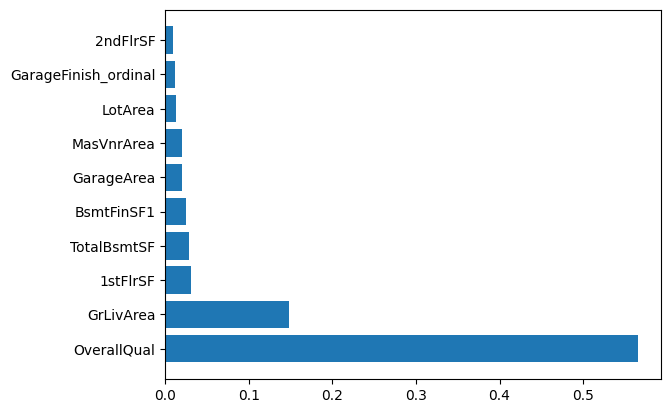

In [16]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

### Setting parameter grid

In [17]:
param_grid = {
    'n_estimators': range(50, 300, 50),
    'max_depth': range(3,24,3),
    'min_samples_split': range(5,20,5),
    'min_samples_leaf': range(1,10),
    'max_features': range(20, 100, 20)
}

### Initialize Model and Grid Search

In [18]:
rf = RandomForestRegressor(random_state=20)

grid_search_rf = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=0,
                           scoring='r2')

grid_search_rf.fit(x_train, y_train)
%time grid_search_rf.fit(x_train, y_train)

CPU times: user 31.3 s, sys: 22 s, total: 53.3 s
Wall time: 17min 50s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20), n_jobs=-1,
             param_grid={'max_depth': range(3, 24, 3),
                         'max_features': range(20, 100, 20),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(5, 20, 5),
                         'n_estimators': range(50, 300, 50)},
             scoring='r2')

### View the best parameters and score

In [19]:
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score R square:", grid_search_rf.best_score_)

Best Parameters: {'max_depth': 15, 'max_features': 80, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score R square: 0.8982693522311065


In [20]:
best_rf = grid_search_rf.best_estimator_

In [21]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 80,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 20,
 'verbose': 0,
 'warm_start': False}

In [22]:
best_rf

RandomForestRegressor(max_depth=15, max_features=80, min_samples_split=5,
                      random_state=20)

### Evaluate on Test Set

In [23]:
final_rf = best_rf.fit(x_train, y_train)

In [24]:
y_train_pred = final_rf.predict(x_train)
y_test_pred = final_rf.predict(x_test)

In [25]:
# R2
r2_5kf_train = final_rf.score(x_train, y_train)
r2_5kf_test = final_rf.score(x_test, y_test)

In [34]:
print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Train R square: 0.9788
Test R square: 0.9154


In [27]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_5kf_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_5kf_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [28]:
print(f"Train Root Mean Squared Error: {rmse_5kf_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_5kf_test:.2f}")

Train Root Mean Squared Error: 11148.48
Test Root Mean Squared Error: 21167.11


In [29]:
rf_feature_importance_final = pd.DataFrame({"model": "random_forest_5fk",
                                            "features": x.columns, 
                                            "importance":final_rf.feature_importances_})

In [30]:
rf_feature_importance_final

,model,features,importance
0,random_forest_5fk,GrLivArea,0.101277
1,random_forest_5fk,LotFrontage,0.007972
2,random_forest_5fk,LotArea,0.016364
3,random_forest_5fk,OverallQual,0.264879
4,random_forest_5fk,OverallCond,0.002835
...,...,...,...
276,random_forest_5fk,Electrical_FuseP,0.000007
277,random_forest_5fk,Electrical_SBrkr,0.000153
278,random_forest_5fk,QrtSold_Q2,0.000511
279,random_forest_5fk,QrtSold_Q3,0.000220


In [31]:
rf_feature_importance_final.sort_values("importance", ascending = False, inplace=True);
rf_feature_importance_final.head(10)

,model,features,importance
3,random_forest_5fk,OverallQual,0.264879
0,random_forest_5fk,GrLivArea,0.101277
47,random_forest_5fk,ExterQual_ordinal,0.100937
24,random_forest_5fk,GarageCars,0.086592
11,random_forest_5fk,TotalBsmtSF,0.046133
25,random_forest_5fk,GarageArea,0.044504
12,random_forest_5fk,1stFlrSF,0.040097
5,random_forest_5fk,YearBuilt,0.031805
42,random_forest_5fk,BsmtQual_ordinal,0.029509
41,random_forest_5fk,KitchenQual_ordinal,0.024937


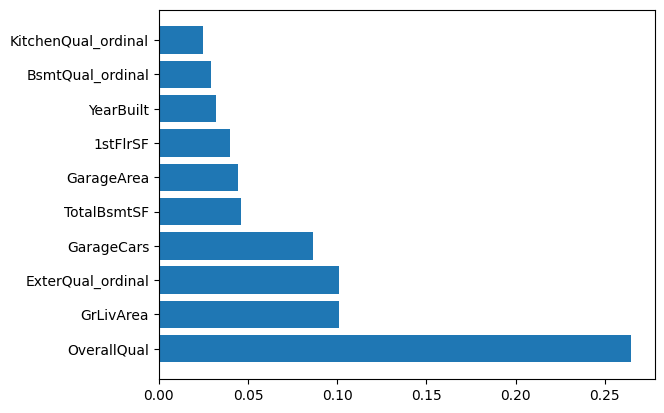

In [32]:
temp = rf_feature_importance_final.iloc[:10,]
plt.barh(temp["features"], temp["importance"]);

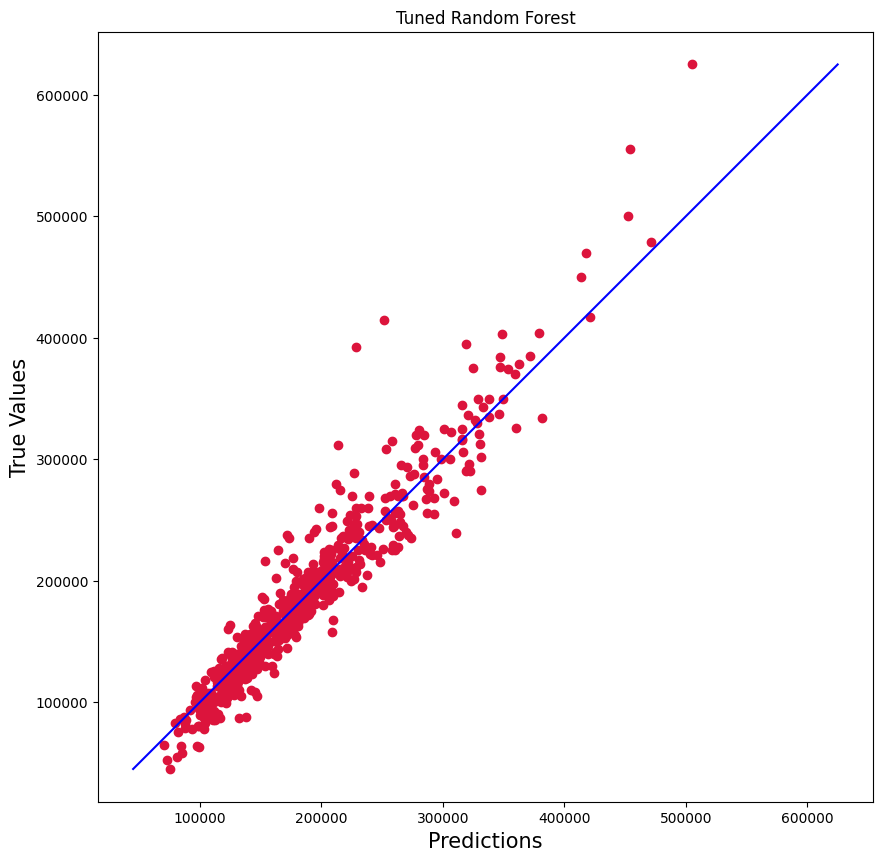

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Random Forest')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [38]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_rf)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(x_test)

#This balances accurate attribution with realistic performance evaluation.

In [39]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': x.columns,
    'mean_abs_shap': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                 feature  mean_abs_shap
3            OverallQual   14566.293808
0              GrLivArea   11653.411871
47     ExterQual_ordinal    8171.938717
24            GarageCars    4344.290761
11           TotalBsmtSF    4128.485776
5              YearBuilt    3853.378509
12              1stFlrSF    3539.863517
25            GarageArea    3325.506476
38   FireplaceQu_ordinal    2946.665167
8             BsmtFinSF1    2854.380685
41   KitchenQual_ordinal    2239.311557
2                LotArea    2015.694544
17              FullBath    1958.726249
42      BsmtQual_ordinal    1890.233765
13              2ndFlrSF    1552.562675
7             MasVnrArea    1517.535036
22            Fireplaces    1302.306003
34  GarageFinish_ordinal    1234.415440
1            LotFrontage    1231.797875
50     house_age_derived    1136.896948
45  BsmtFinType1_ordinal     969.200111
6           YearRemodAdd     902.626453
23           GarageYrBlt     749.678526
21          TotRmsAbvGrd     685.494423


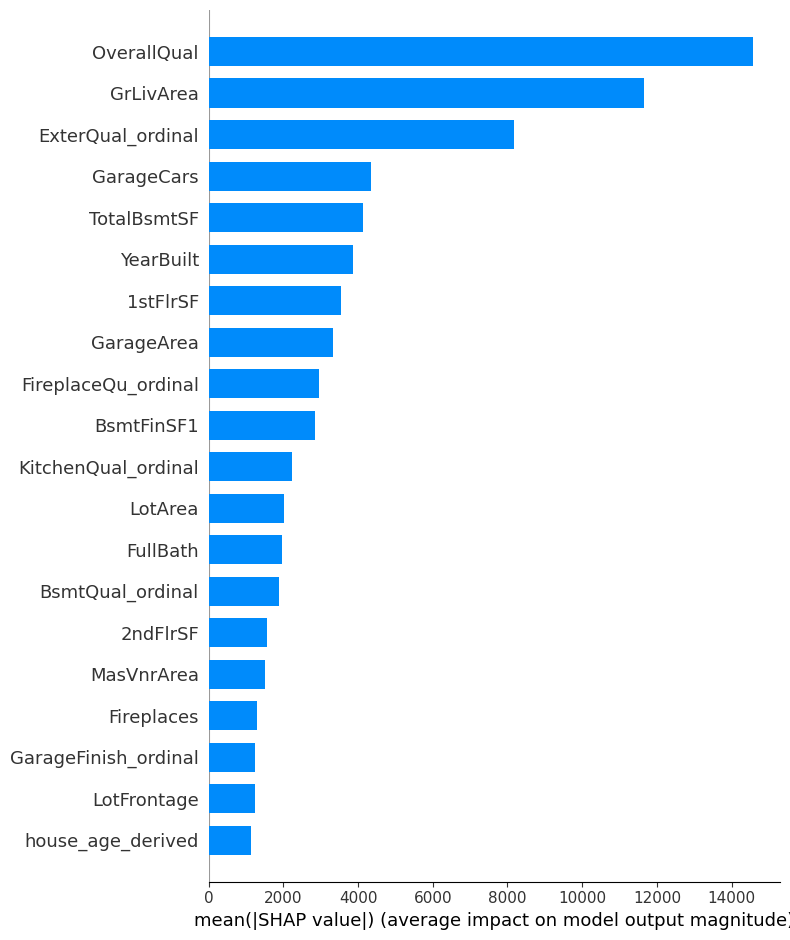

In [40]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, x_test, plot_type='bar')

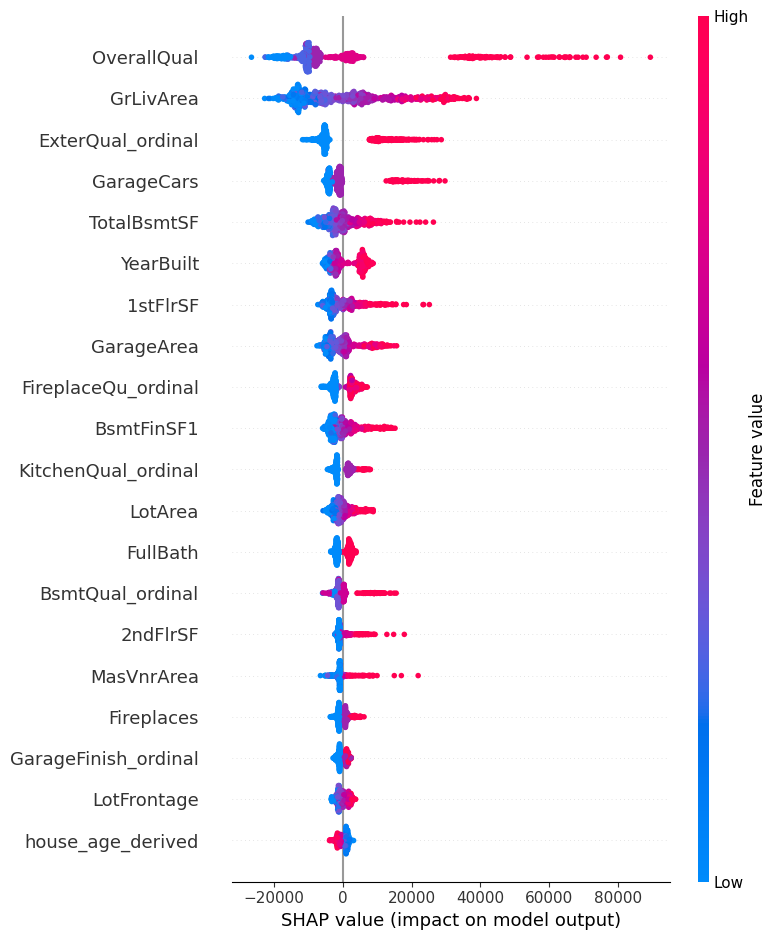

In [41]:
# summary violin plot
shap.summary_plot(shap_values, x_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

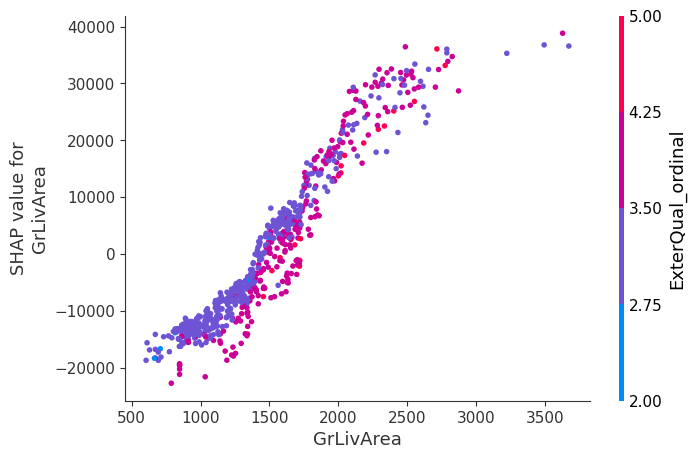

In [42]:
shap.dependence_plot('GrLivArea', shap_values, x_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

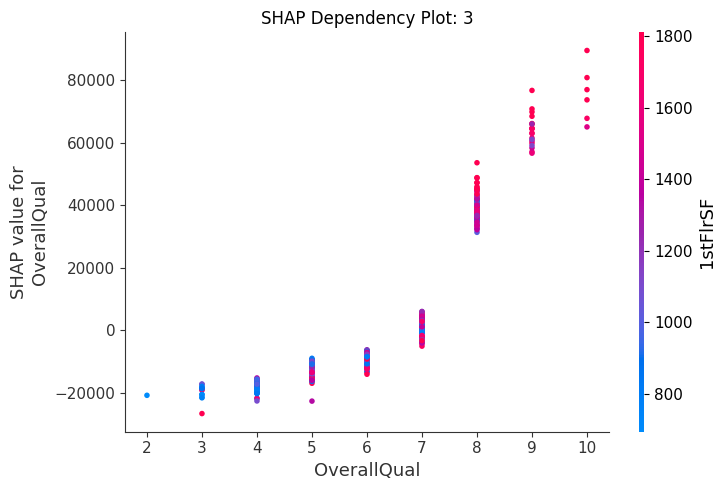

<Figure size 600x400 with 0 Axes>

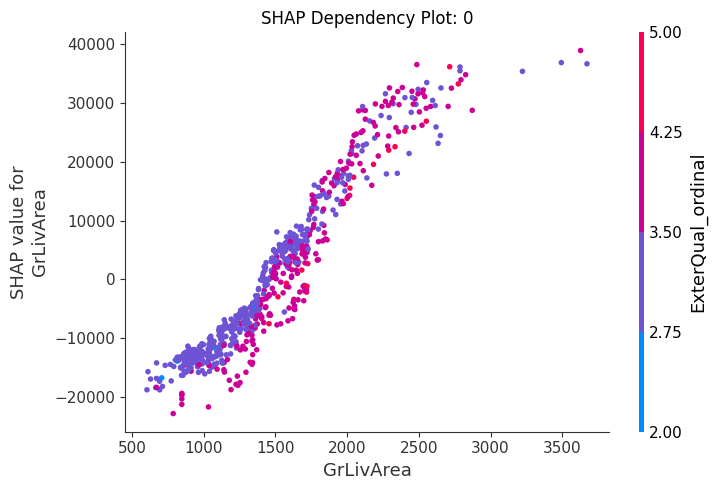

<Figure size 600x400 with 0 Axes>

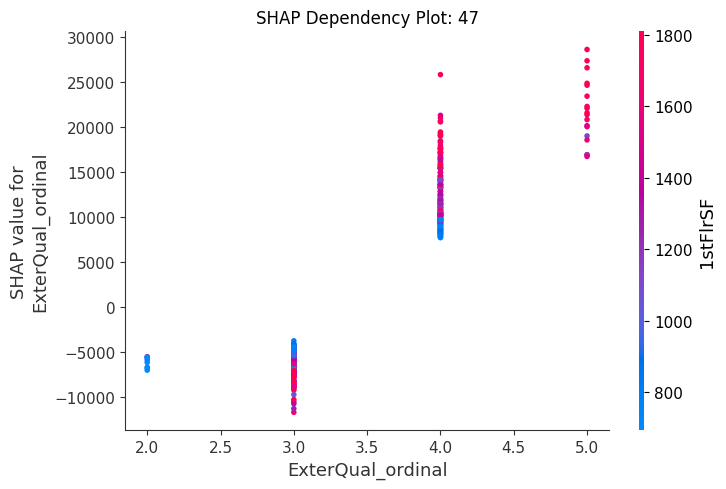

<Figure size 600x400 with 0 Axes>

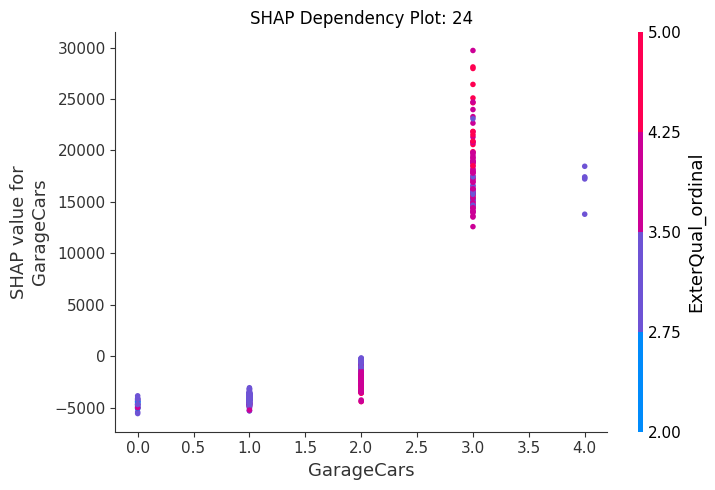

<Figure size 600x400 with 0 Axes>

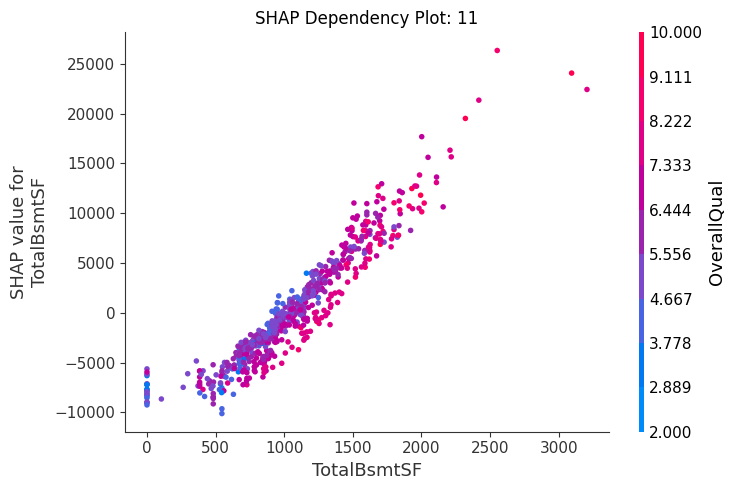

<Figure size 600x400 with 0 Axes>

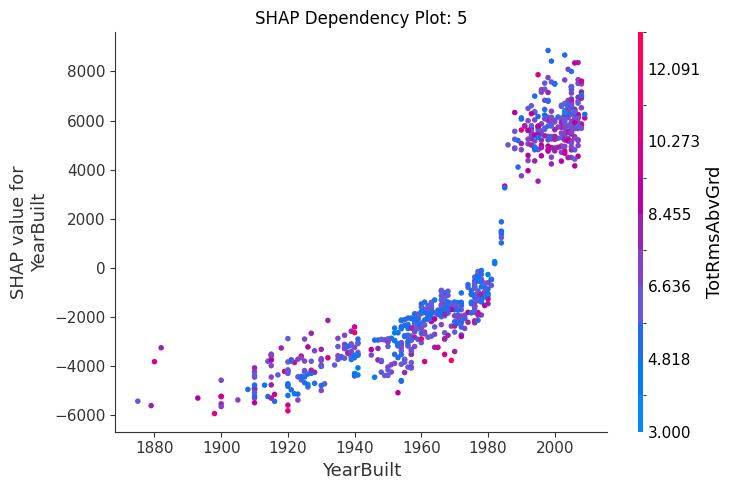

<Figure size 600x400 with 0 Axes>

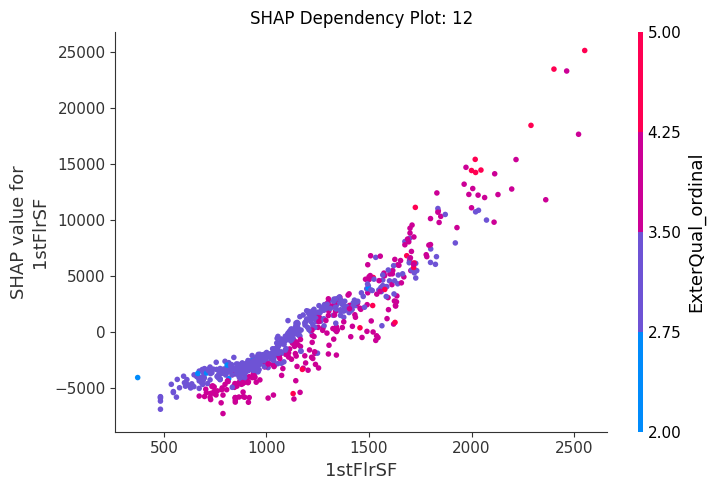

<Figure size 600x400 with 0 Axes>

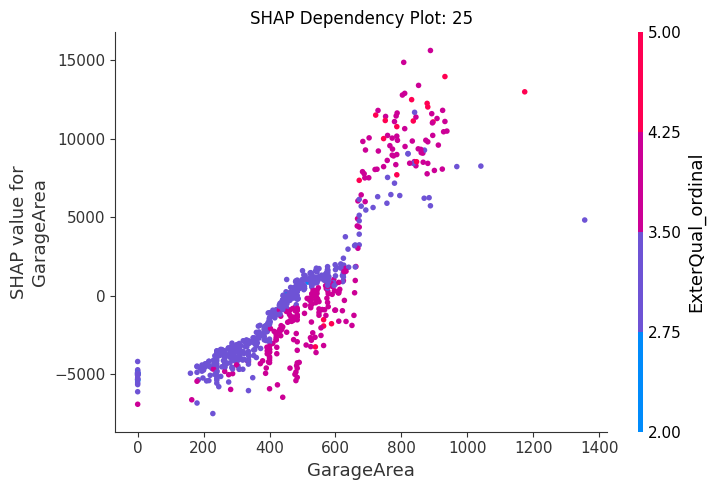

<Figure size 600x400 with 0 Axes>

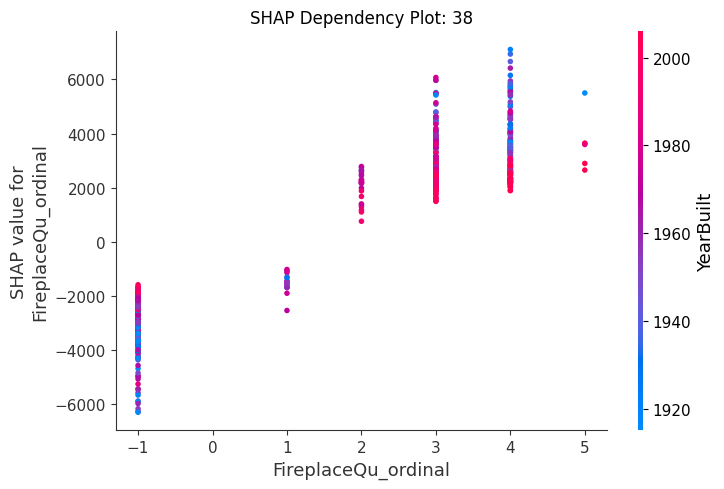

<Figure size 600x400 with 0 Axes>

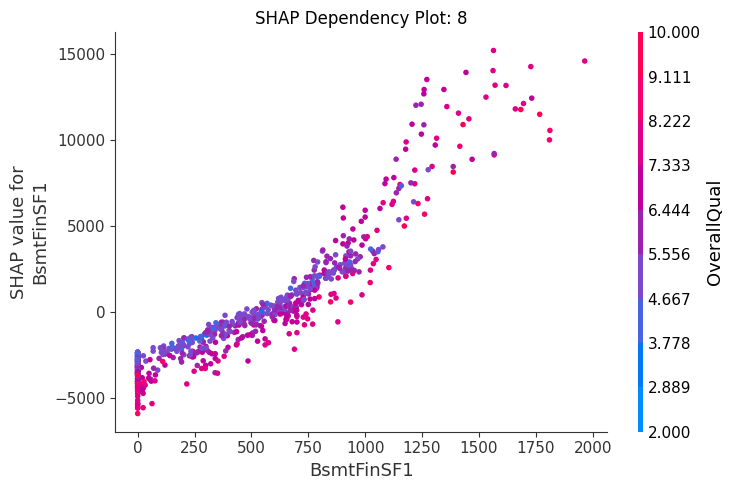

<Figure size 600x400 with 0 Axes>

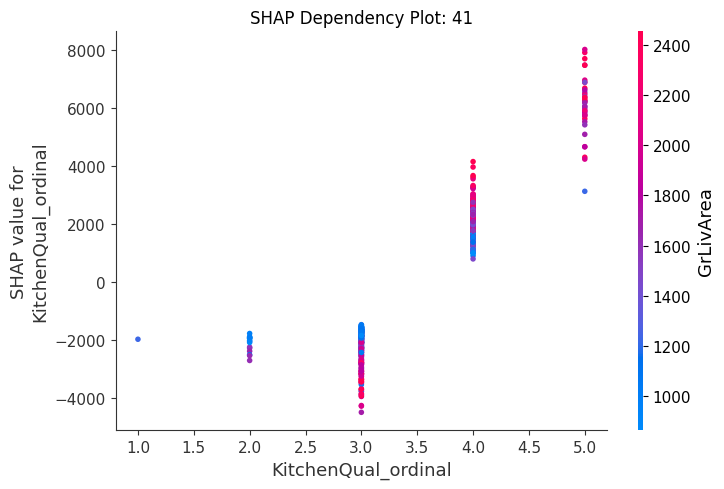

<Figure size 600x400 with 0 Axes>

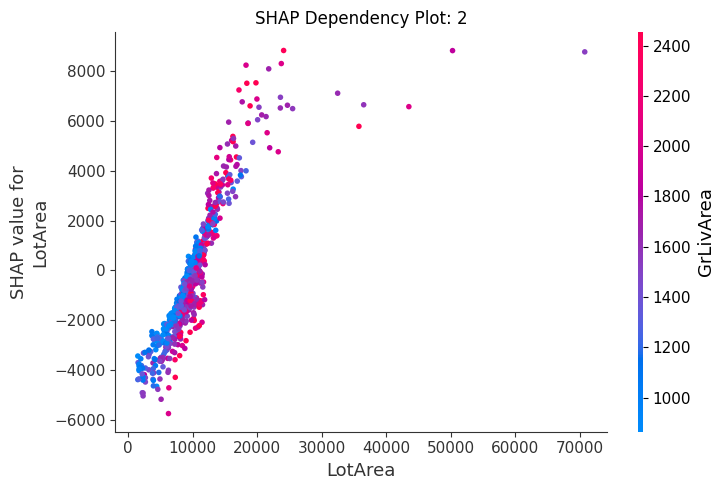

<Figure size 600x400 with 0 Axes>

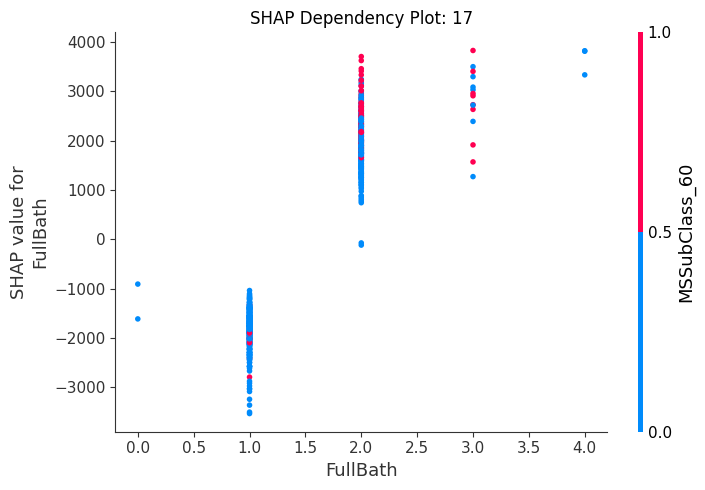

<Figure size 600x400 with 0 Axes>

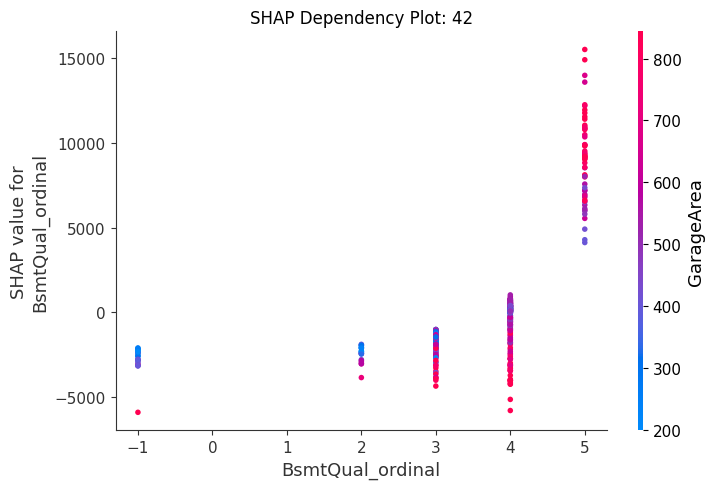

<Figure size 600x400 with 0 Axes>

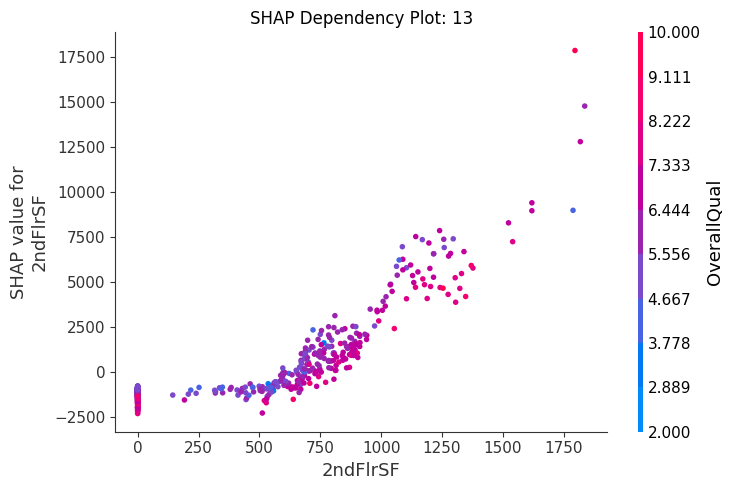

<Figure size 600x400 with 0 Axes>

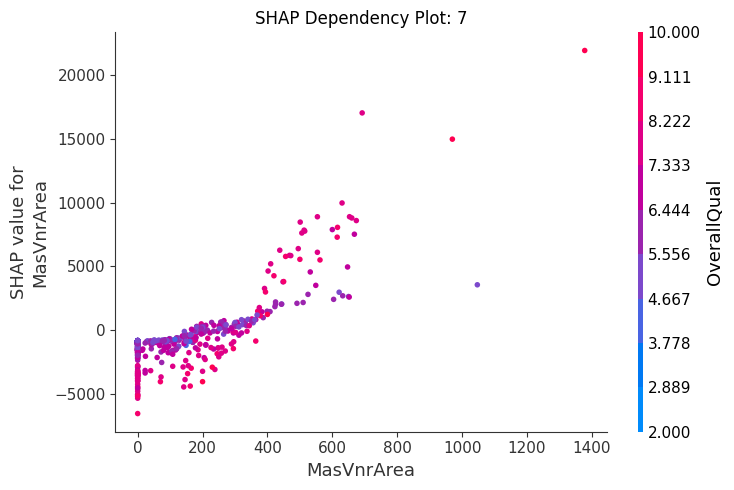

<Figure size 600x400 with 0 Axes>

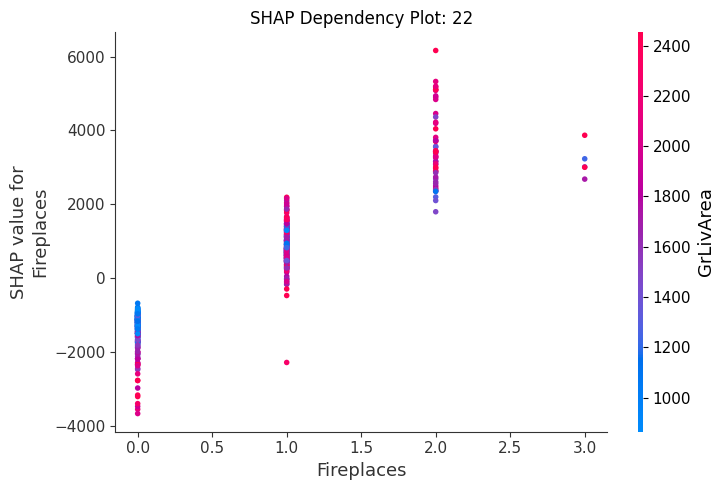

<Figure size 600x400 with 0 Axes>

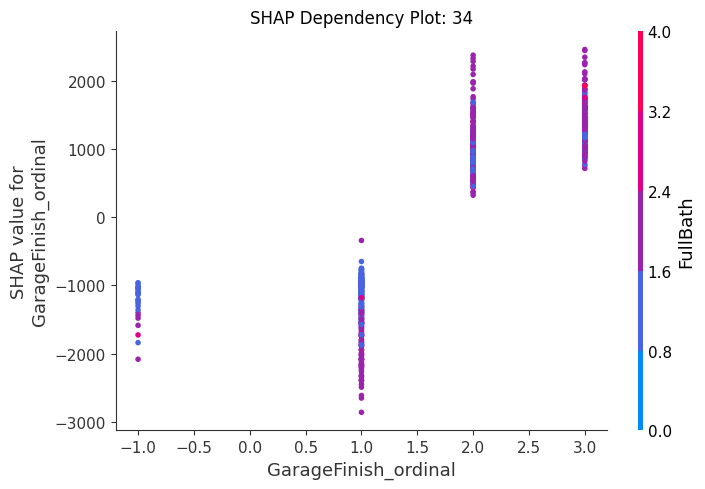

<Figure size 600x400 with 0 Axes>

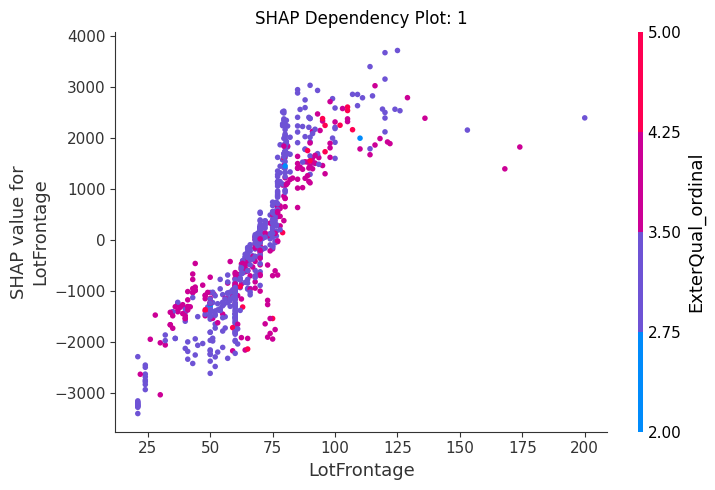

<Figure size 600x400 with 0 Axes>

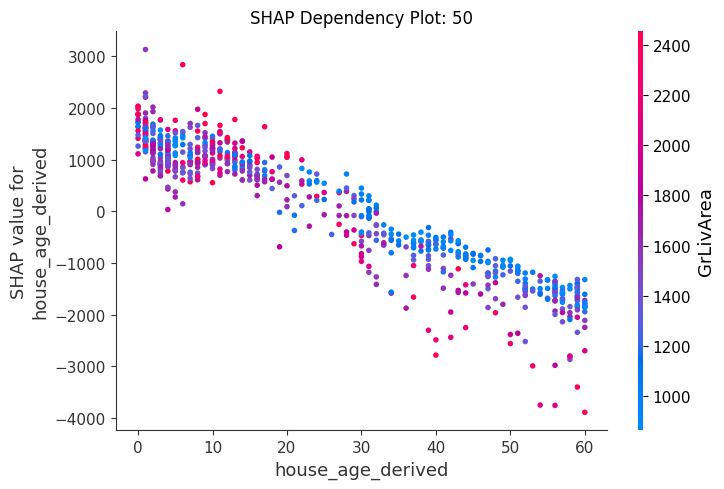

In [43]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        x_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

### Extract the list of features and features that each one is most correlated with

In [44]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = x_test.corr()

In [45]:
most_correlated = {}

for feature in x_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [46]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature']

In [47]:
correlation_df

,feature,most_correlated_feature
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,LotArea
2,LotArea,RoofMatl_WdShngl
3,OverallQual,ExterQual_ordinal
4,OverallCond,YearBuilt
...,...,...
222,Electrical_FuseP,MSSubClass_190
223,Electrical_SBrkr,Electrical_FuseF
224,QrtSold_Q2,MoSold_6
225,QrtSold_Q3,MoSold_7


In [48]:
# limit the above list to top 20 features ranked by mean abs SHAP values
rf_SHAP_feature_final = pd.merge(
    shap_importance_sorted.head(20), 
    correlation_df, 
    how='left',
    on = 'feature'
)

rf_SHAP_feature_final['model'] = 'random_forest_5fk'
rf_SHAP_feature_final = rf_SHAP_feature_final[['model', 'feature', 'most_correlated_feature', 'mean_abs_shap']]
rf_SHAP_feature_final

,model,feature,most_correlated_feature,mean_abs_shap
0,random_forest_5fk,OverallQual,ExterQual_ordinal,14566.293808
1,random_forest_5fk,GrLivArea,TotRmsAbvGrd,11653.411871
2,random_forest_5fk,ExterQual_ordinal,OverallQual,8171.938717
3,random_forest_5fk,GarageCars,GarageArea,4344.290761
4,random_forest_5fk,TotalBsmtSF,1stFlrSF,4128.485776
5,random_forest_5fk,YearBuilt,Foundation_PConc,3853.378509
6,random_forest_5fk,1stFlrSF,TotalBsmtSF,3539.863517
7,random_forest_5fk,GarageArea,GarageCars,3325.506476
8,random_forest_5fk,FireplaceQu_ordinal,Fireplaces,2946.665167
9,random_forest_5fk,BsmtFinSF1,BsmtFinType1_ordinal,2854.380685


In [49]:
rf_feature_importance_final.head(20)

,model,features,importance
3,random_forest_5fk,OverallQual,0.264879
0,random_forest_5fk,GrLivArea,0.101277
47,random_forest_5fk,ExterQual_ordinal,0.100937
24,random_forest_5fk,GarageCars,0.086592
11,random_forest_5fk,TotalBsmtSF,0.046133
25,random_forest_5fk,GarageArea,0.044504
12,random_forest_5fk,1stFlrSF,0.040097
5,random_forest_5fk,YearBuilt,0.031805
42,random_forest_5fk,BsmtQual_ordinal,0.029509
41,random_forest_5fk,KitchenQual_ordinal,0.024937
